# MDA - RBF model

In this notebook, we will perform a analysis using one of our most used methods, which involves MDA + RBF algorithms. The process will be the next:

* First, the areas where the study is wanted to be performed are selected.
* Next, we calculate the PCs of these areas, given the hourly / daily storm surge of the locations in that area.
* After calculating the Stormsurge-PCs and the SLP (local) principal components, we then choose N cases from the total dataset, using the MDA algorithm.
* Finally, we use RBF to interpolate the final storm-surge surface in all the areas / locations!!

## Maximum Dissimilarity Algorithm (MDA)

In this way, the first important step to carry out this method is the selection of the maximum dissimilar cases, so the posterior reconstruction of all the cases can be performed correctly:

```{figure} ../media/images/mdacroquis.png
---
height: 400px
name: mdacroquis
---
This is a sketch representation of how the MDA algorithm works
```

This sketch shows the workflow followed in the selection step. The data is firstly normalized for the correct performance of the algorithm, then the euclidean distance is used for the calculation of the distance between the different vectors in the dataset. Finally, the selected data is de-normalized so it can be used and plotted together with the original information.

As it can be seen, the variables used are:

$$
\boxed{
\textrm{Variables: } \:\: PC1, \:\: PC2 \:\: ... \:\: PCn; \:\: SS1 \:\: ... \:\: SSn
}
$$

where $PCn$ refers to the principal components of the sea-level-pressure fields and the $SSn$ variables belongs to the principal components of the $n$ locations of the selected area.

## Reconstruction of the coastal wave climate with RBF

Once we have the selected cases, we now have a lot of different situations with
different characteristics all along the coast so the reconstruction of the storm surge climate can be done.

The reconstruction of the storm surge in shallow waters is carried out by
an interpolation from the selected case series that have been selected. The interpolation technique used is based on radial basis
functions (RBF), very suitable for data with high dimensionality and not evenly
distributed. There is a series of values of the real function
$f(x_i) \:\:\: i = 1, ..., N$ in the points $x_1 , ..., x_N$. The RBF
interpolation technique considers that the RBF function approximation consists of a linear combination of symmetrical radial functions centered on the given points. The objective function has the following expression:

$$
\boxed{
RBF(x) = p(x) + \sum_{i=1}^{N}a_i\Phi\left ( \left \| x-x_i \right \| \right )
}
$$

interpolating the given values as follows:

$$
\boxed{
RBF(x_i) = f_i \:\:\: i = 1 ,..., N
}
$$

where $RBF$ is the interpolation function, $p(x)$ is the linear polynomial in all the
variables involved in the problem, $a_i$ are the RBF adjustment coefficients, $\Phi$ is the
basic radial function, $||\cdot||$ is the Euclidean norm and $x_i$ are the centres of
the RBF interpolation.

```{figure} ../media/images/rbf-color.png
---
width: 500px
name: rbf-color
---
This is the interpolation surface of the RBF technique
```

The polynomial $p(x)$ in the expression of the RBF interpolation function is defined as a
monomial base ${p_0, p_1 ,..., p_d}$. The first is a monomial, consisting of a number of grade one monomials equal to the dimensionality of the data, where $b = {b_0 , b_1 ,..., b_d}$ are the coefficients of these monomials.

The radially based functions can have different expressions. Some of these
radial functions contain a shape parameter that plays a very important role
in the precision of the technique. In the methodology of propagation of the maritime climate, it has been considered the Gaussian radial function that depend on a shape parameter.

In [1]:
# common
import os

# pip
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
import sys
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.config import default_region_reduced
from sscode.data import Loader, load_moana_hindcast_ss
from sscode.mda_rbf import MDA_RBF_Model
from sscode.plotting.validation import plot_stats

## Load data and linear model stats

We first load the data, and plot some multilinear regression statistics to compare...


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



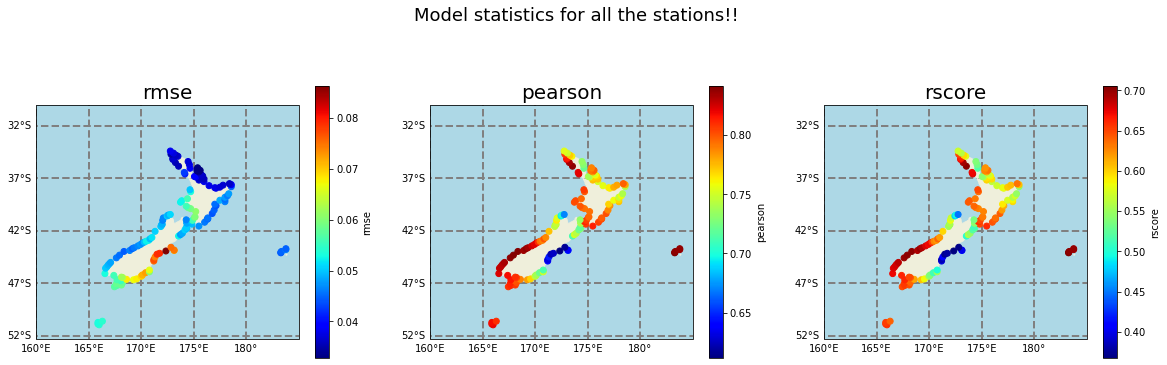

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], load_winds=True, 
    plot=False, time_resample='1D'
)

# load the moana v2 hindcast (more ss and mask)
# ss_grid = (load_moana_hindcast_ss(daily=True) * \
#     xr.open_dataarray('../data/bathymetry/nz_300m_elev_mask.nc'))\
#     .dropna(dim='lon',how='all').dropna(dim='lat',how='all')
# ss_moanav2_site = xr.Dataset(
#     {
#         'ss': (('time','site'), ss_grid.values.reshape(
#             -1,len(ss_grid.lon)*len(ss_grid.lat))),
#         'lon': (('site'), list(ss_grid.lon.values)*int(
#             (len(ss_grid.lon)*len(ss_grid.lat))/len(ss_grid.lon))),
#         'lat': (('site'), np.repeat(ss_grid.lat.values,
#             (len(ss_grid.lon)*len(ss_grid.lat))/len(ss_grid.lat)))
#     }, coords={
#         'site': np.arange(len(ss_grid.lon)*len(ss_grid.lat)),
#         'time': ss_grid.time.values
#     }
# ).dropna(dim='site',how='all')
# plot results

lm_stats = True
if lm_stats:
    stats_local = xr.open_dataset(
        '../data/statistics/models/stats_lm_local_daily.nc'
    )
    plot_stats(stats_local,plot_stats=['rmse','pearson','rscore'])

## Create the MDA+RBF model

In the cell below, we create the instance of the class `MDA_RBF_Model`, that is located at `sscode/mda_rbf.py`, and shown below:

```python
    class MDA_RBF_Model(object):
        """
        This MDA+RBF model allows the user to perform a model which consists in
        reconstructing / interpolating the storm surge in different locations or
        shores around New Zealand.

        Two options are available for the reconstruction of the SS:

            - First, the storm surge might be directly reconstructed in some
            desired locations (this is what we will be doing to compare with
            the results obtained in the linear and knn models)

            - Moreover, we add here an extra option which consists in giving
            the MDA+RBF interpolating machine the pcs extracted from the ss in 
            several locations from a desired shore. In this case, we will use
            the slp fields pcs to interpolate the non-linear surface of these
            ss-pcs, and then we will reconstruct the real ss in all the locations

        """

        def __init__(self, ss_data, # this should be the loaded moana with Loader class
            slp_data, # this will be used to calculate the local predictors
            dict_to_pca, # this is the parameters dictionary to calculate pca from the slp
            model_metrics=['expl_var','mae','mse','me',
                'medae','tweedie', # check theory
                'ext_mae','ext_mse','ext_rmse','ext_pearson',
                'bias','si','rmse','pearson','spearman','rscore'
            ], # model metrics to evaluate performance
            ss_data_attrs: tuple = ('lon','lat','site','ss'), # ss attrs
            sites_to_analyze = list(np.unique(
                [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
                  1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
                  1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
                ]
            )[::3]), # sites to analyze in case individual analysis is performed
            # lons / lats in case shore analysis is required
            lons: list = [168.1, 171.4, 167.5, 171.1, 173.5, 173.3, 175.1, 177.9, 172.6], 
            lats: list = [-44.2, -41.9, -47.2, -45.4, -42.5, -40.7, -40.2, -40.1, -34.3],
            min_dist_th: list = [130, 130, 140, 110, 110, 90, 90, 130, 400],
            extra_help: list = [ # this helps to stay in the wanted shore of NZ
                ('lon',1.5),('lon',1.5),('lat',1.5),('lon',1.5),('lon',1.5),
                ('lat',0.7),('lat',0.7),('lon',1.5),('lon',3.5)
            ], time_resample: str = '1D', # this is important, try 6H
            verbose: bool = True, plot: bool = True):

            """
            As always, we have the initializator/constructor function, where the 
            instance of the class is created, giving some initial parameters

            Args:
                ss_data (xarray.Dataset): This is the previously loaded moana datasets.
                    This might be just the shore moana dataset or the one including
                    the continental platform until 300m of depth, which is now saved
                    in data/storm_surge_data/moana_hindcast_v2/moana_ss_300m_daily.nc
                slp_data (xarray.Dataset): This is the slp data, also loaded with the
                    usually used, Loader class in data.py
                dict_to_pca (dict): This is the parameters dictionary with all the
                    requested information to calculate the slp principal components      
                model_metrics (list): This is a list with all the model metrics to 
                    evaluate model performance          
                ss_data_attrs (tuple): This is a tuple with the main info regarding
                    the ss data, for posterior calculations
                sites_to_analyze (list): This is the list with all the individual sites
                    where the MDA+RBF technique will be performed
                lons (list): Longitudes of the "middle" location of the shores
                lats (list): Latitudes of the "middle" location of the shores
                min_dist_th (list): Distances in km to find the nearest points to
                    the lons/lats specified
                extra_help (list): This is extra information, regarding the "dimension"
                    in which the shore is projected, so fake nodes are not introduced
                    in the pcs analysis
                time_resample (str, optional): As usually, time resample step
                verbose, plot (bools): Whether to log / plot the results

            ***** OPTIONS ARE:
                - Give the desired sites_to_analyze!!
                - Give lon/lat locations and extra_help/min_dist_th for 
                    shore analysis!!

            """
```

where this is the aspect of the initializator, and all the methods of the class and additional funtions must be consulted in the python script!!


 Initializing the MDA + RBF constructor... 


 in locations: [116, 578, 999, 1217], 

 with coords: ([168.34508816120908, 173.72544080604533, 174.02770780856423, 174.81360201511333],[-46.62520764994737, -42.4141452030056, -39.04490025426387, -36.78609400494574]) 


 data will be resampled to 1D 

 and the PC analysis             will be calculated using the parameters 

 {'pres_vars': ('SLP', 'longitude', 'latitude'), 'calculate_gradient': True, 'winds': (False, None), 'wind_vars': ('wind_proj_mask', 'lon', 'lat'), 'time_lapse': 1, 'time_resample': '1D', 'region': (True, (160, 185, -30, -52)), 'pca_plot': (True, False, 1), 'verbose': True, 'pca_ttls': ['SLP in t', 'Grad in t', 'SLP in t-1', 'Grad in t-1'], 'pca_borders': None} 


 lets calculate the slp pcs... 

 

             The slp pcs will be calculated for all the locations / shores...             

pcs matrix calculation for site / shore 1
 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields.

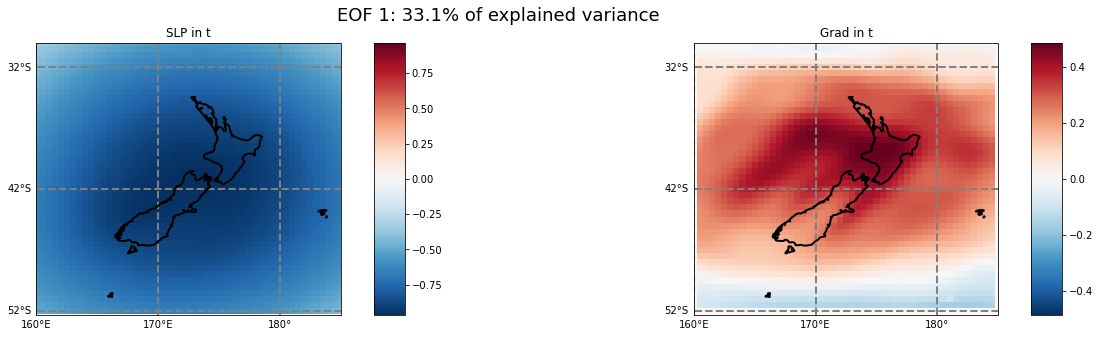

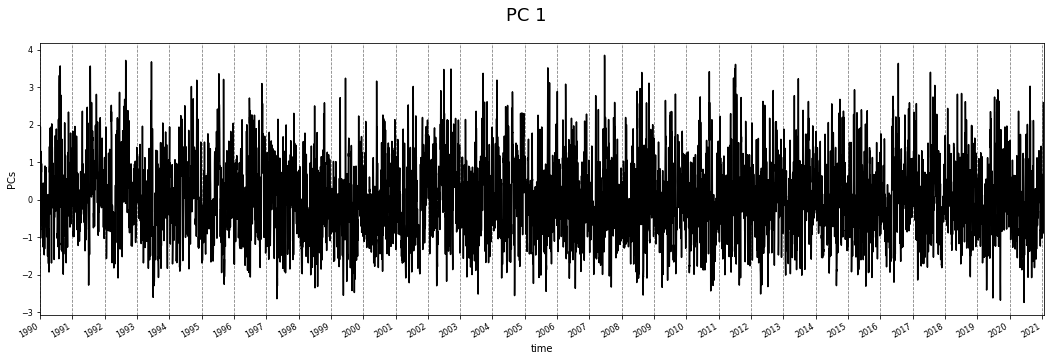

pcs matrix calculation for site / shore 2
 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 45, 51) 


 calculating PCs matrix with shape: 
 (11353, 4590) 


 plotting 1 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



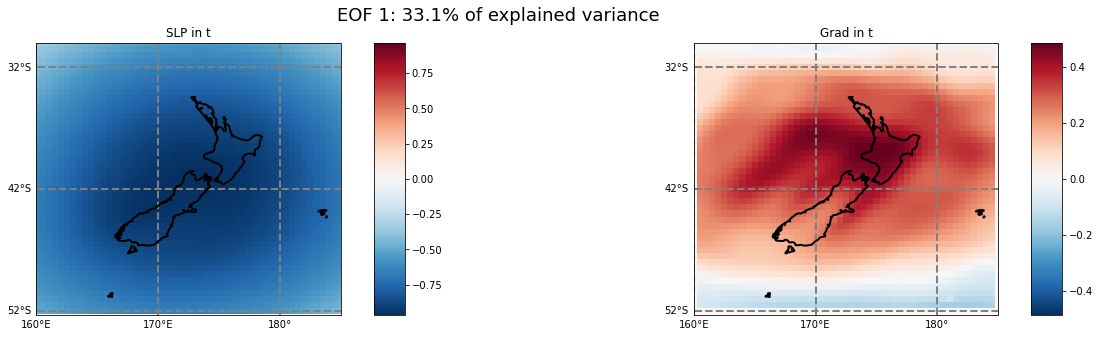

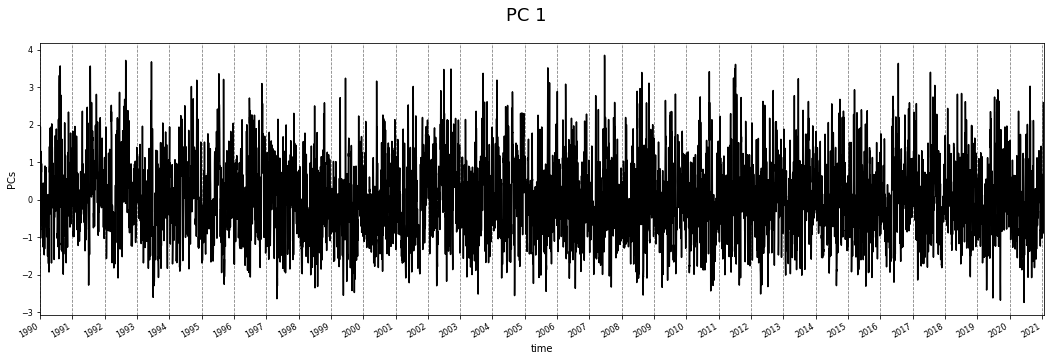

pcs matrix calculation for site / shore 3
 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 45, 51) 


 calculating PCs matrix with shape: 
 (11353, 4590) 


 plotting 1 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



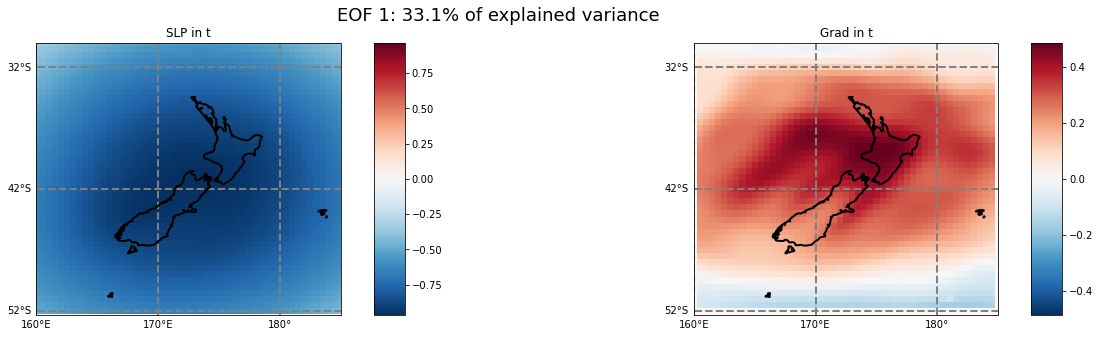

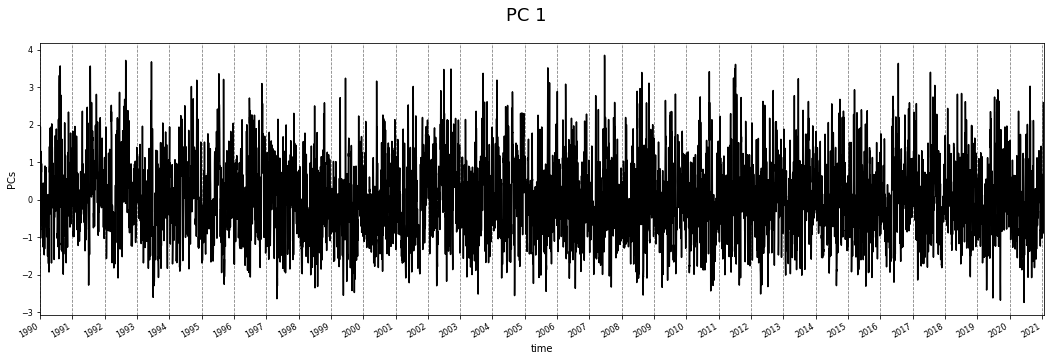

pcs matrix calculation for site / shore 4
 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 45, 51) 


 calculating PCs matrix with shape: 
 (11353, 4590) 


 plotting 1 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



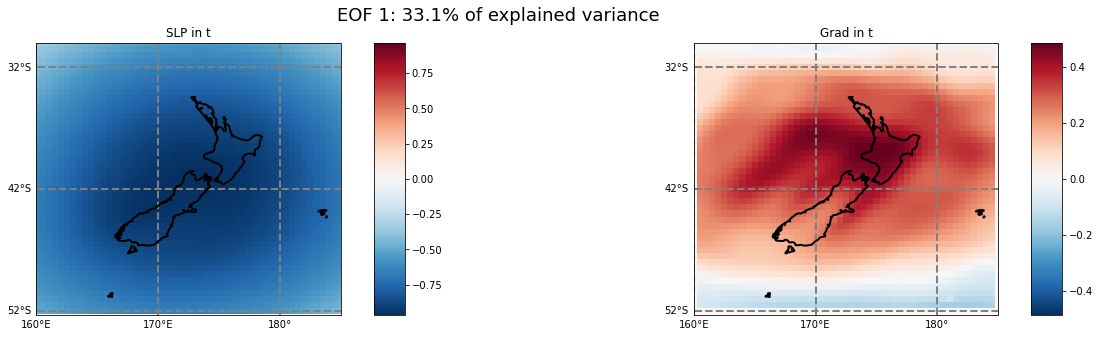

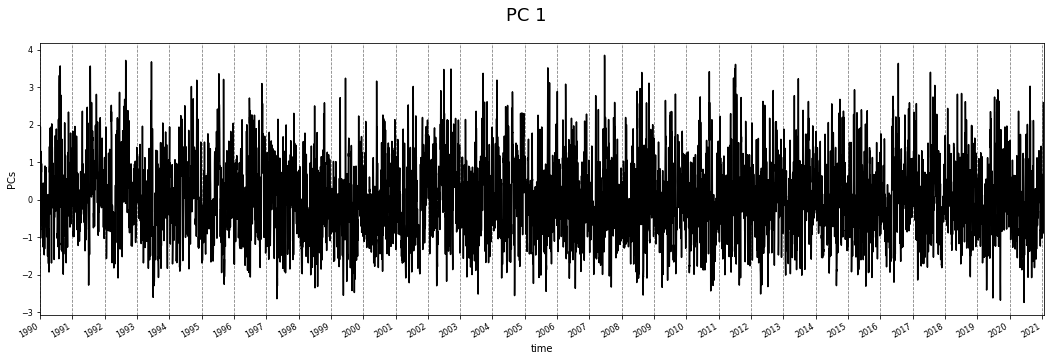

In [3]:
# dict to pca
pca_attrs_default = {
    'pres_vars': ('SLP','longitude','latitude'),
    'calculate_gradient': True,
    'winds': (False,None), # winds will not be used
    'wind_vars': ('wind_proj_mask','lon','lat'),
    'time_lapse': 1, # 1 equals to NO time delay,
    'time_resample': '1D', 'region': (True,default_region_reduced),
    'pca_plot': (True,False,1), 'verbose': True,
    'pca_ttls': [
        'SLP in t','Grad in t','SLP in t-1','Grad in t-1'], 
    'pca_borders': None
}
sites_to_analyze = np.unique(
    [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
      1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
      1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]
)

# construct the MDA + RBF object
mda_rbf_model = MDA_RBF_Model(
    load_cfsr_moana_uhslc.predictand, # load_cfsr_moana_uhslc.predictand, 
    load_cfsr_moana_uhslc.predictor_slp,
    pca_attrs_default, # all params to calculate the pcs
    model_metrics=['expl_var','mae','mse','me',
        # 'medae','tweedie', # check theory
        # 'ext_mae','ext_mse','ext_rmse','ext_pearson',
        'bias','si','rmse','pearson','spearman','rscore'
    ],
    sites_to_analyze=list(sites_to_analyze)[::8]
)

```{warning}
Run the CELL below to run all the combinations, but be careful with the time it might take. Moreover, if the num_samples_ini parameter is too big, the searching of the optimal sigma in the RBF funtion might not converge!!
```


 Lets interpolate the SS using all the calculated             pcs (slp + ss) and the MDA+RBF technique!!             This interpolation will be performed in all the locations!! 


 Lets reconstruct the SS for location 1!! 


 ------------------------------------------------------------- 


 MDA + RBF with 0.85 per of pcs and 500 samples!! 

 which means 12 PCs... 


 ------------------------------------------------------------- 





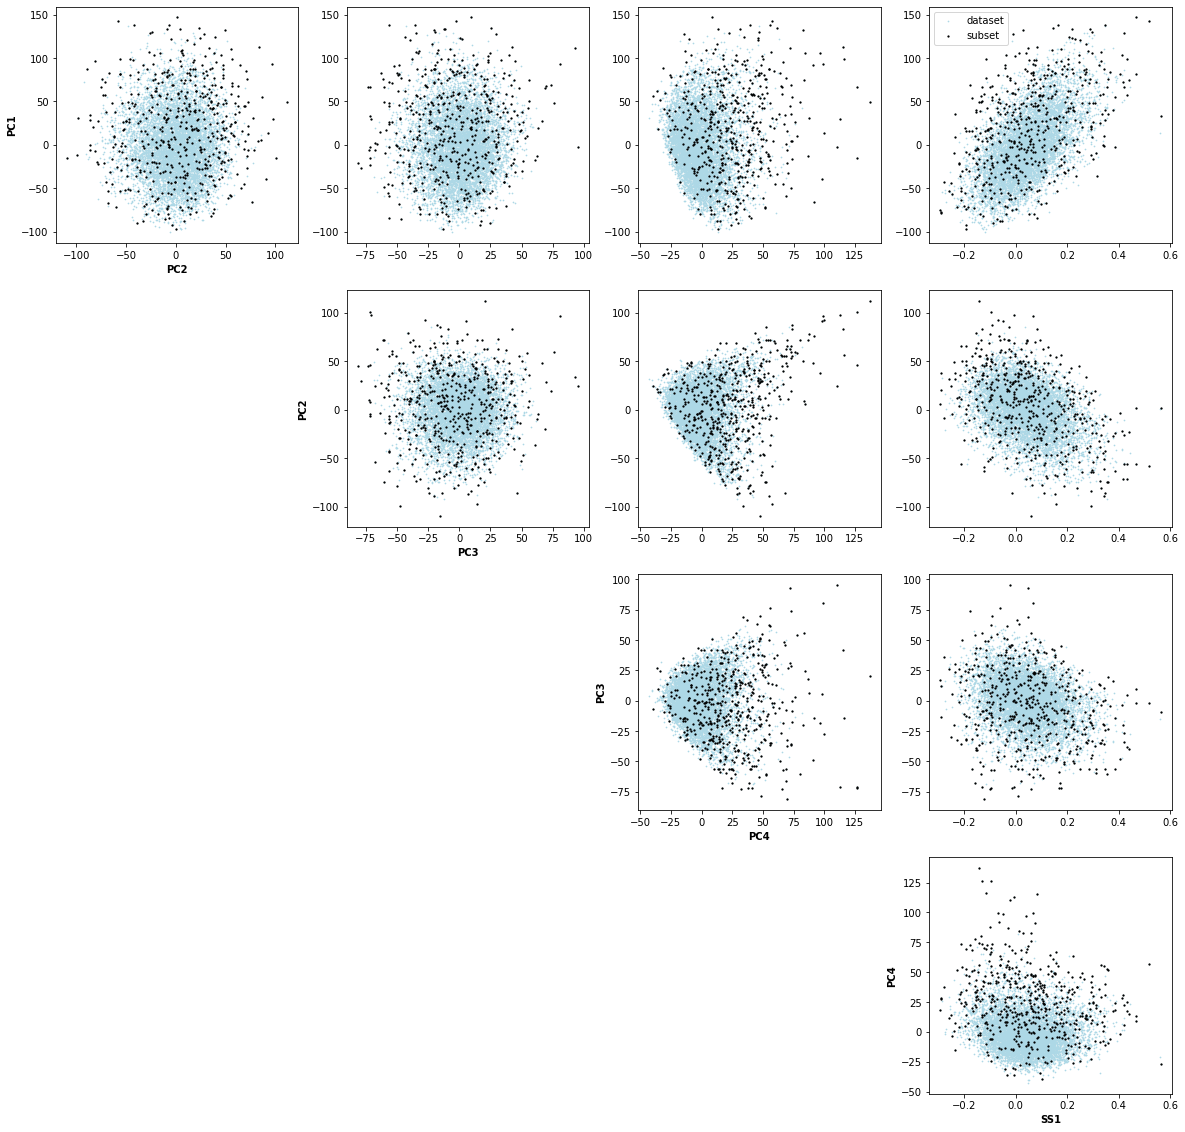

We finally have 509 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 16.93 | interpolation: 0.53 | sigma: 0.5307


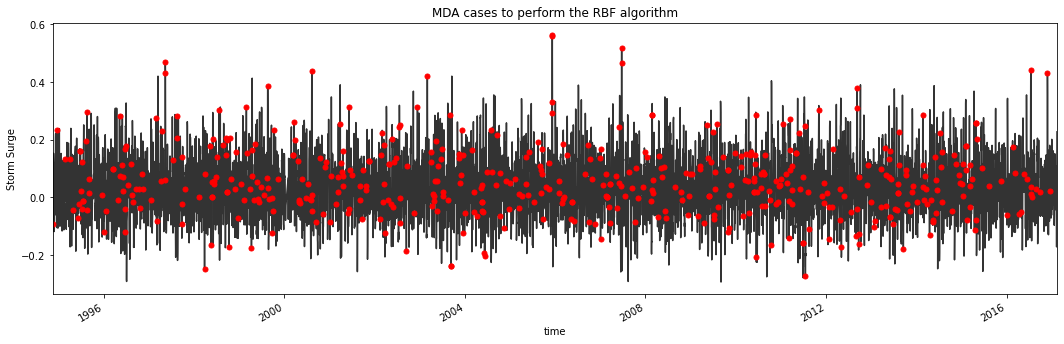

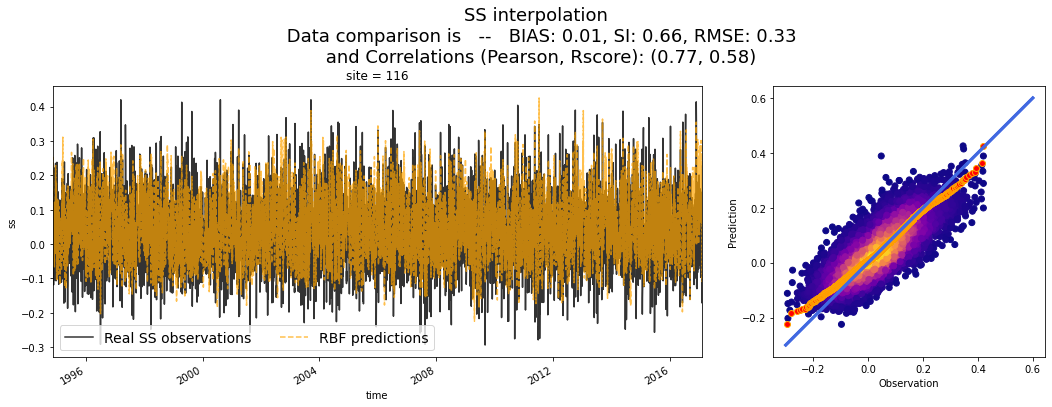


 ------------------------------------------------------------- 


 MDA + RBF with 0.9 per of pcs and 800 samples!! 

 which means 18 PCs... 


 ------------------------------------------------------------- 





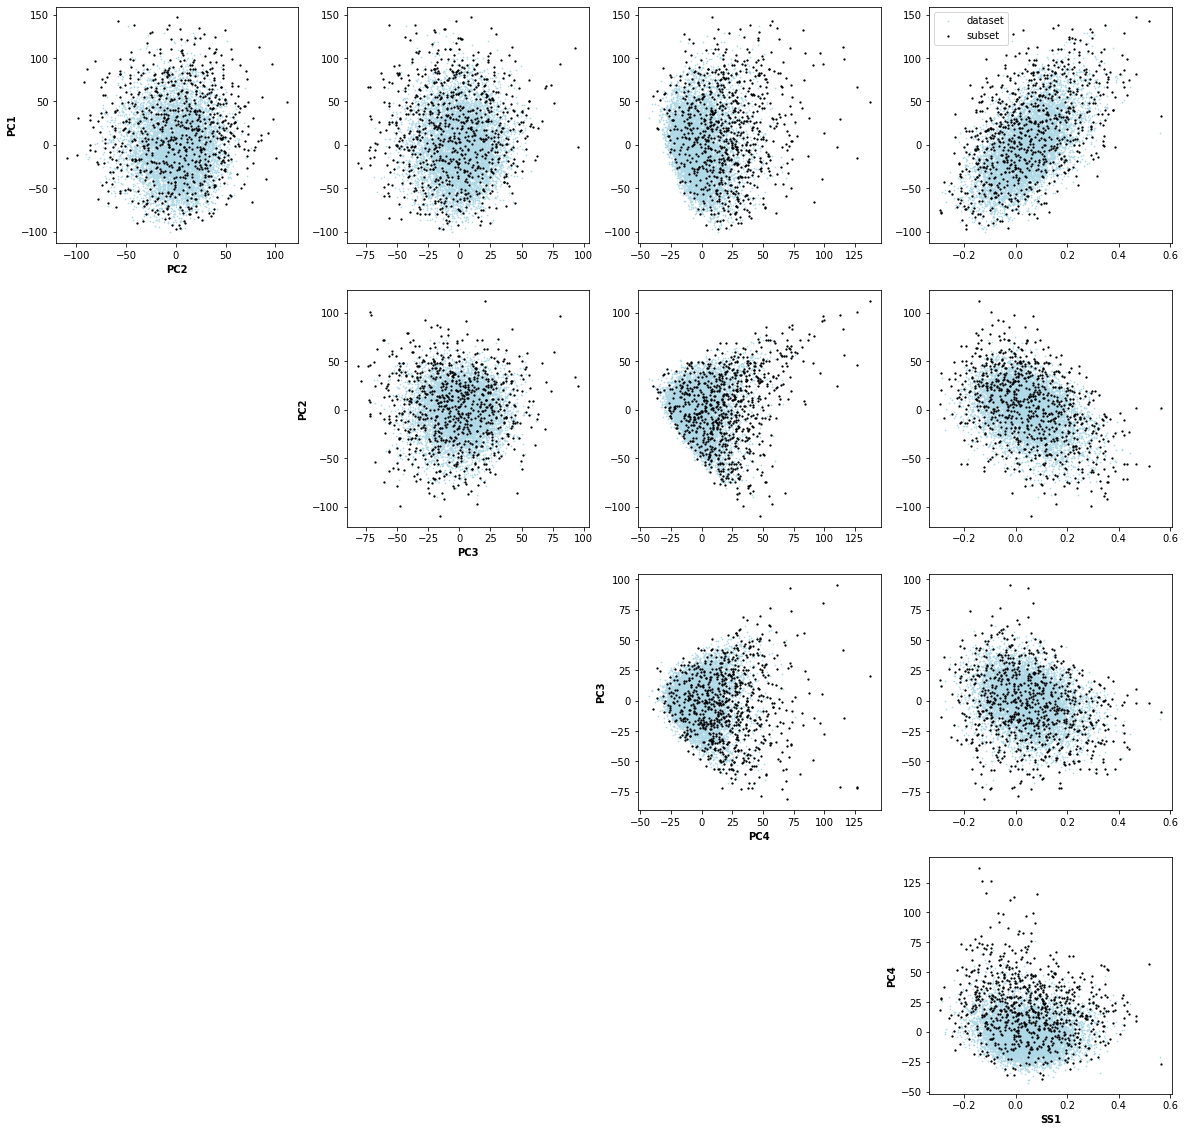

We finally have 808 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 26.70 | interpolation: 0.64 | sigma: 0.6353


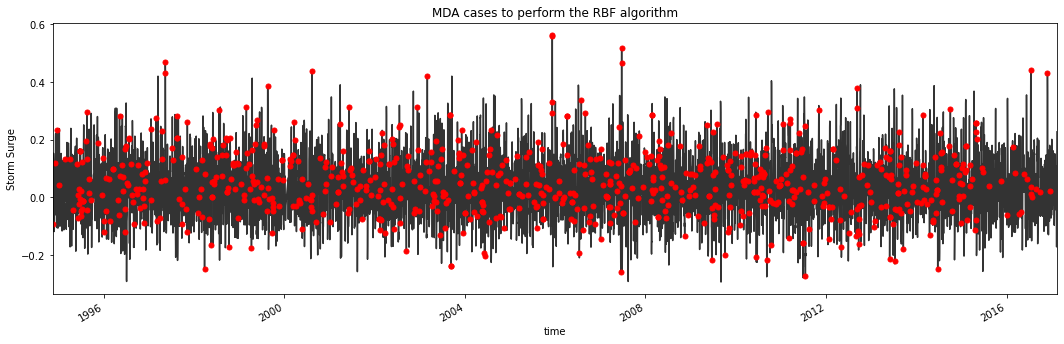

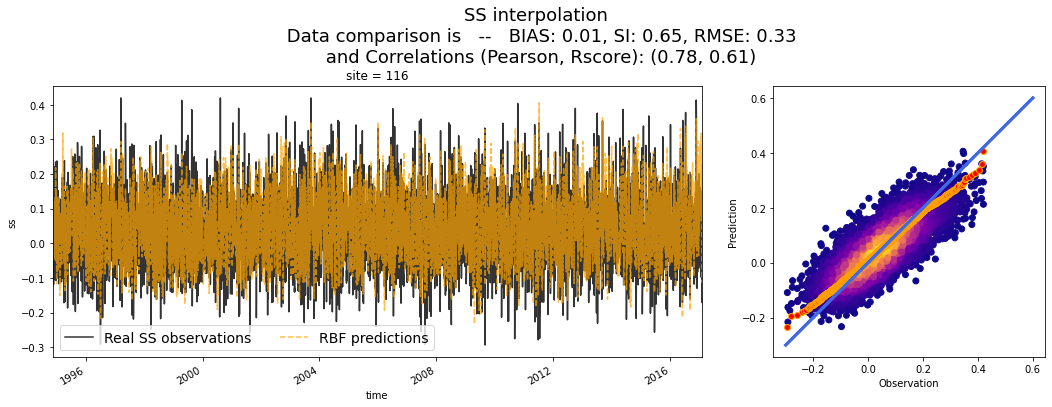


 Lets plot the SS reconstructions for location 1!! 



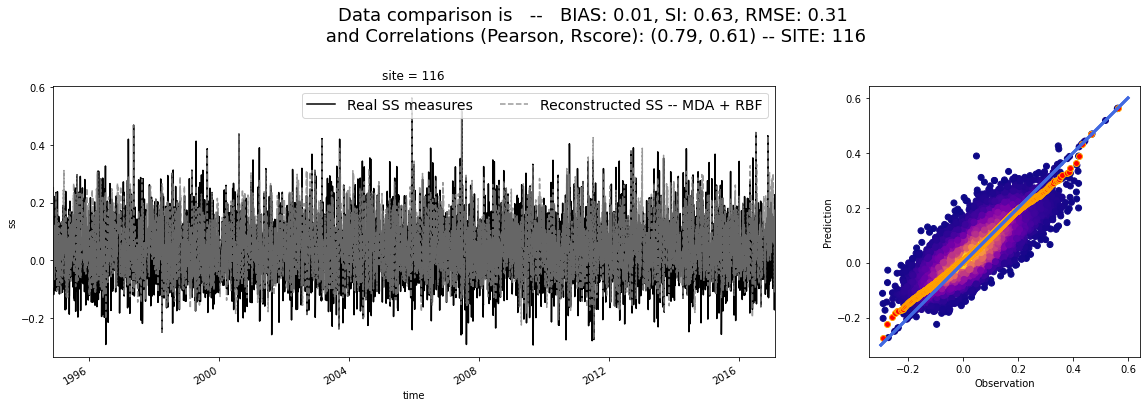

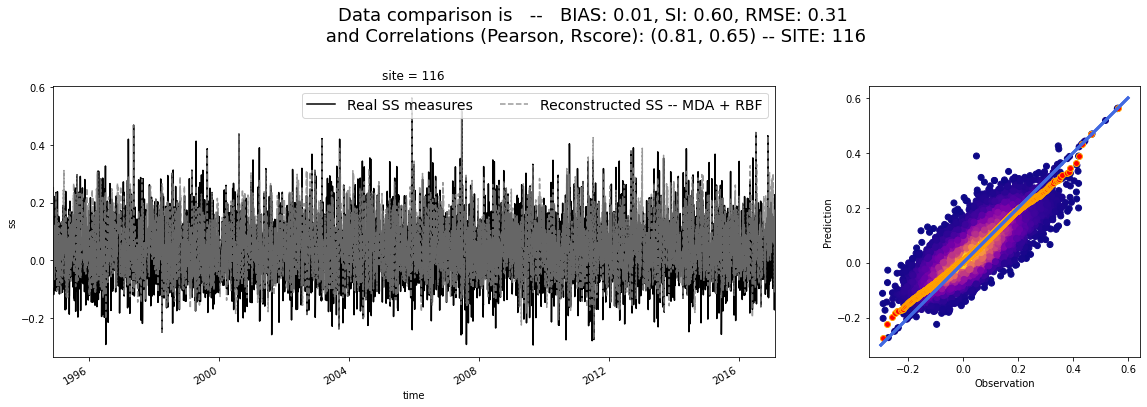


 Lets reconstruct the SS for location 2!! 


 ------------------------------------------------------------- 


 MDA + RBF with 0.85 per of pcs and 500 samples!! 

 which means 12 PCs... 


 ------------------------------------------------------------- 





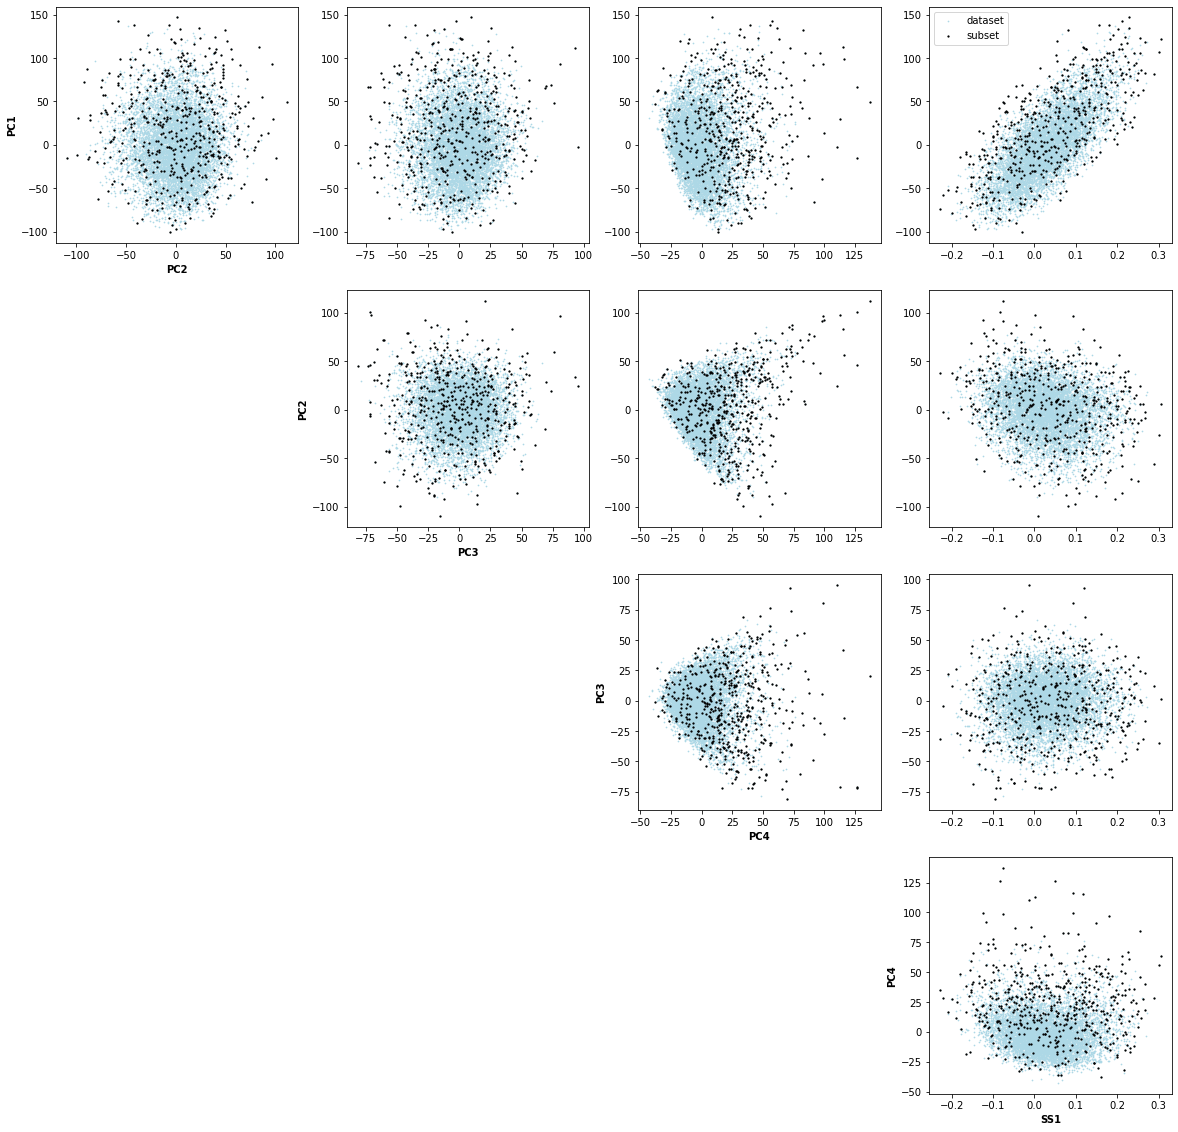

We finally have 509 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 9.49 | interpolation: 0.44 | sigma: 0.4443


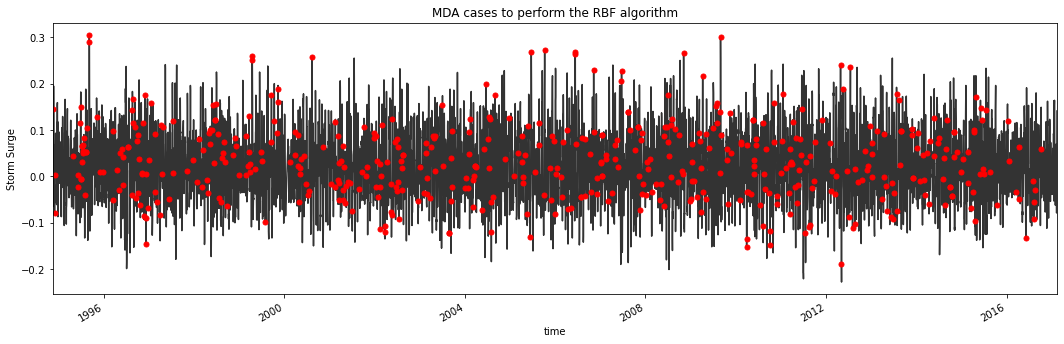

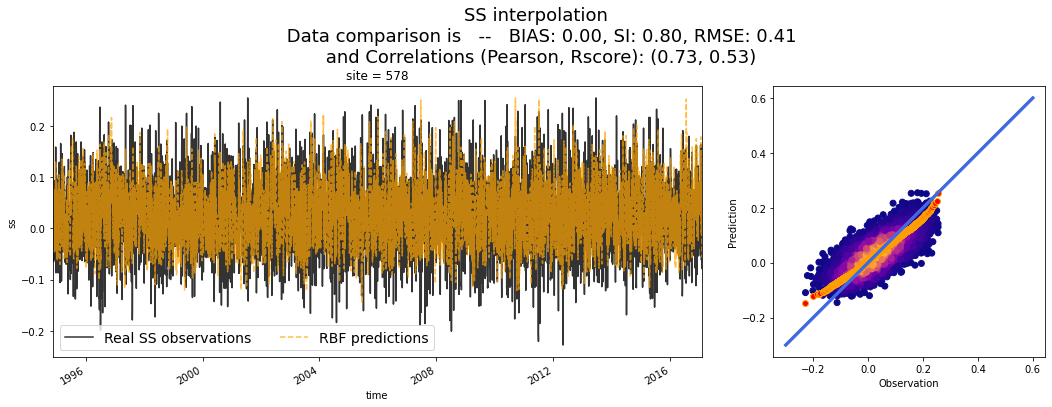


 ------------------------------------------------------------- 


 MDA + RBF with 0.9 per of pcs and 800 samples!! 

 which means 18 PCs... 


 ------------------------------------------------------------- 





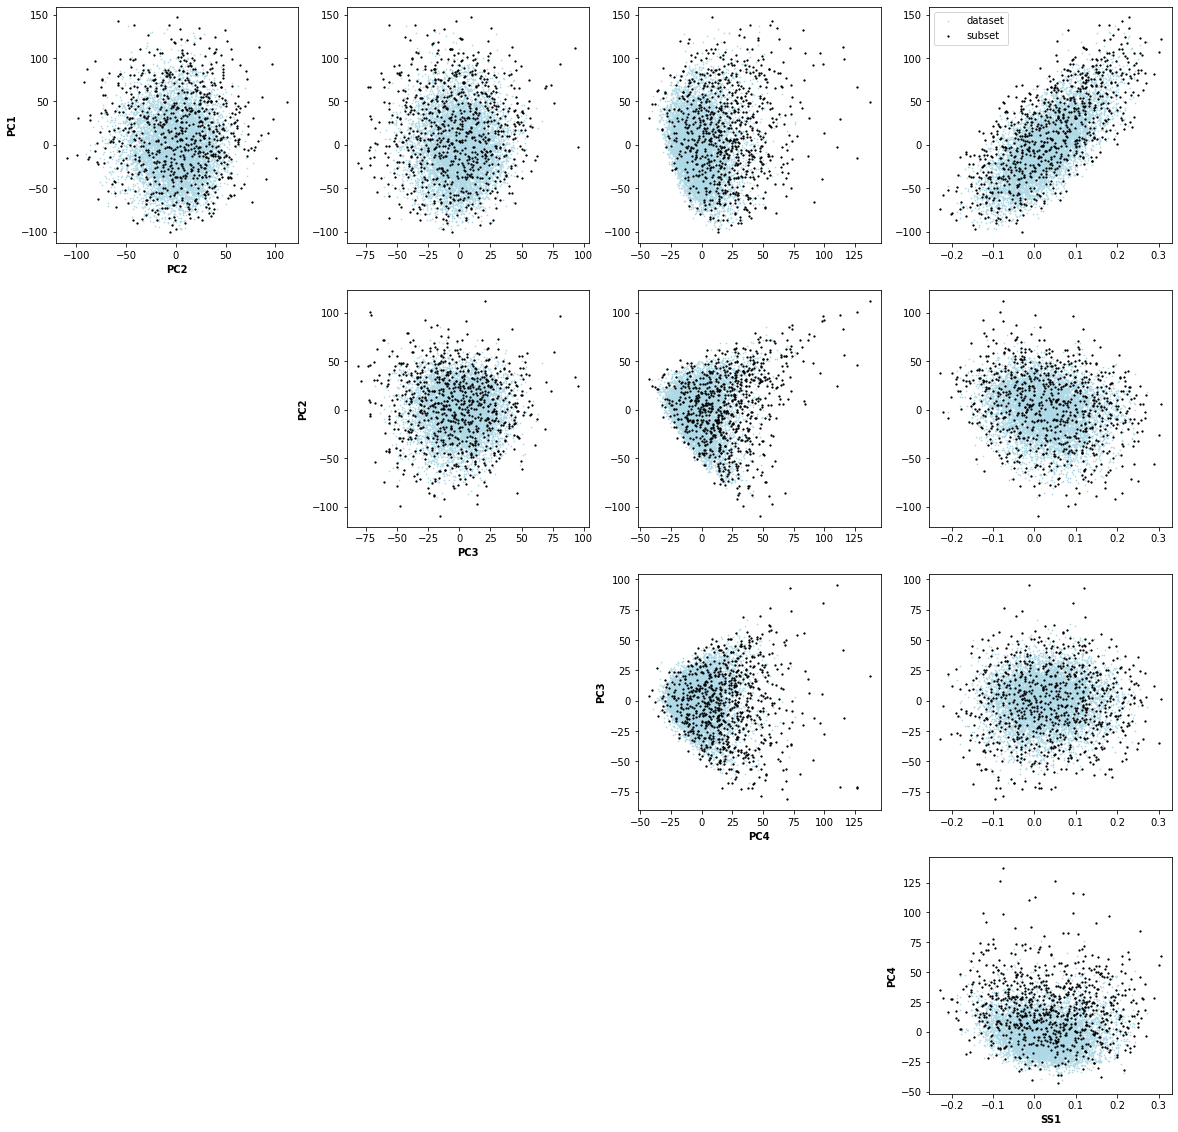

We finally have 809 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 29.48 | interpolation: 0.65 | sigma: 0.6517


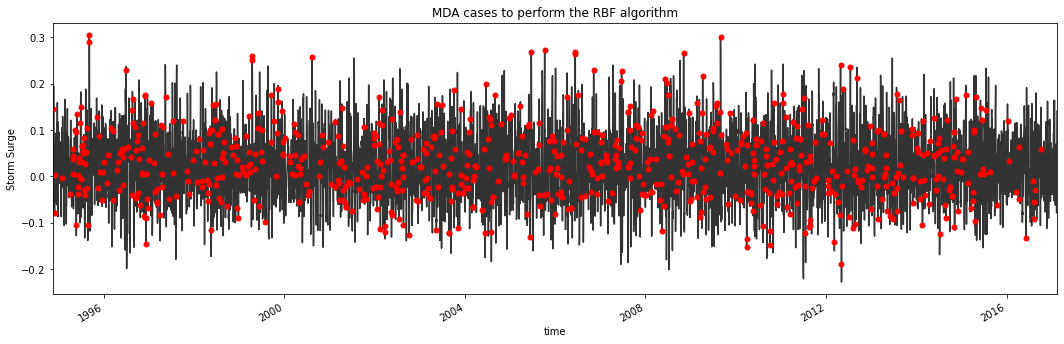

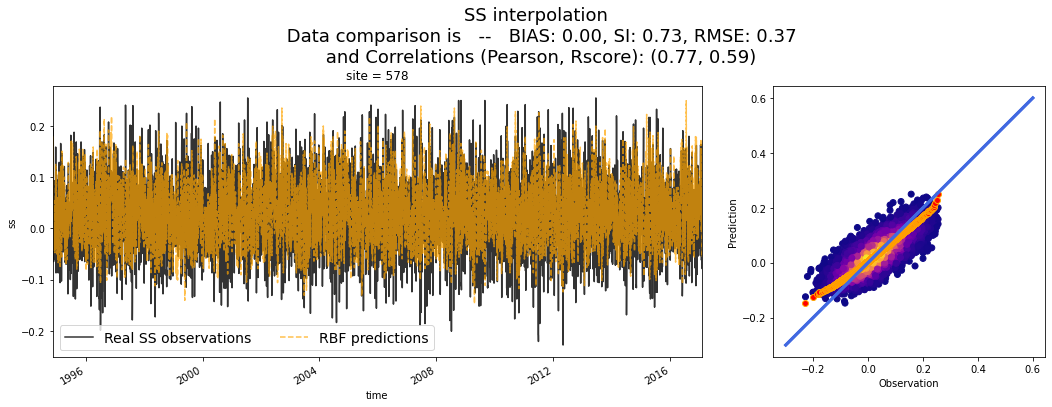


 Lets plot the SS reconstructions for location 2!! 



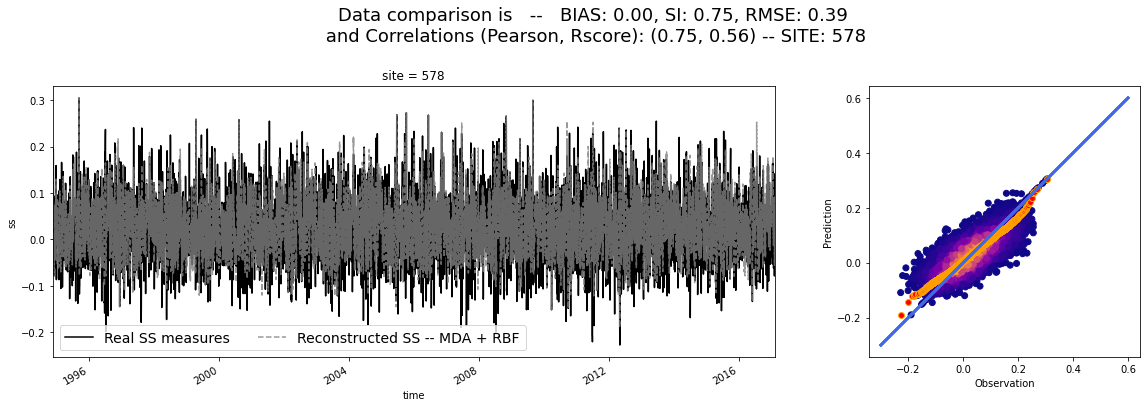

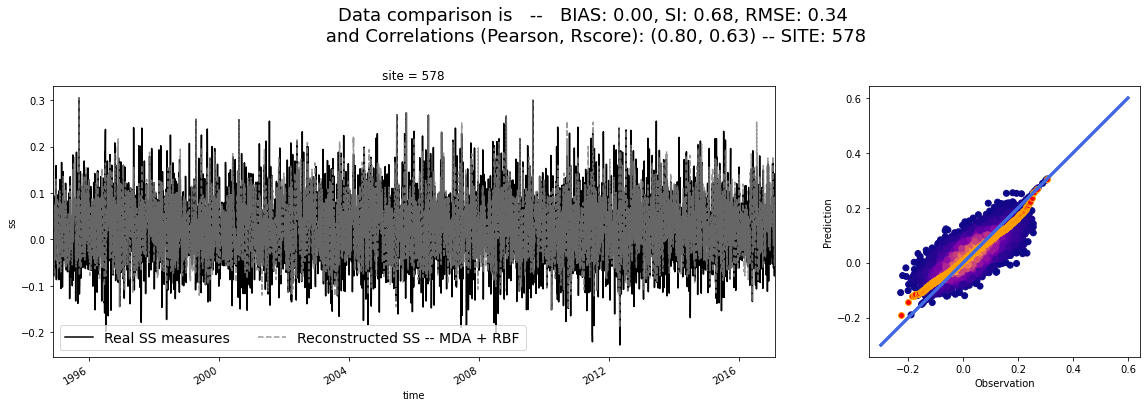


 Lets reconstruct the SS for location 3!! 


 ------------------------------------------------------------- 


 MDA + RBF with 0.85 per of pcs and 500 samples!! 

 which means 12 PCs... 


 ------------------------------------------------------------- 





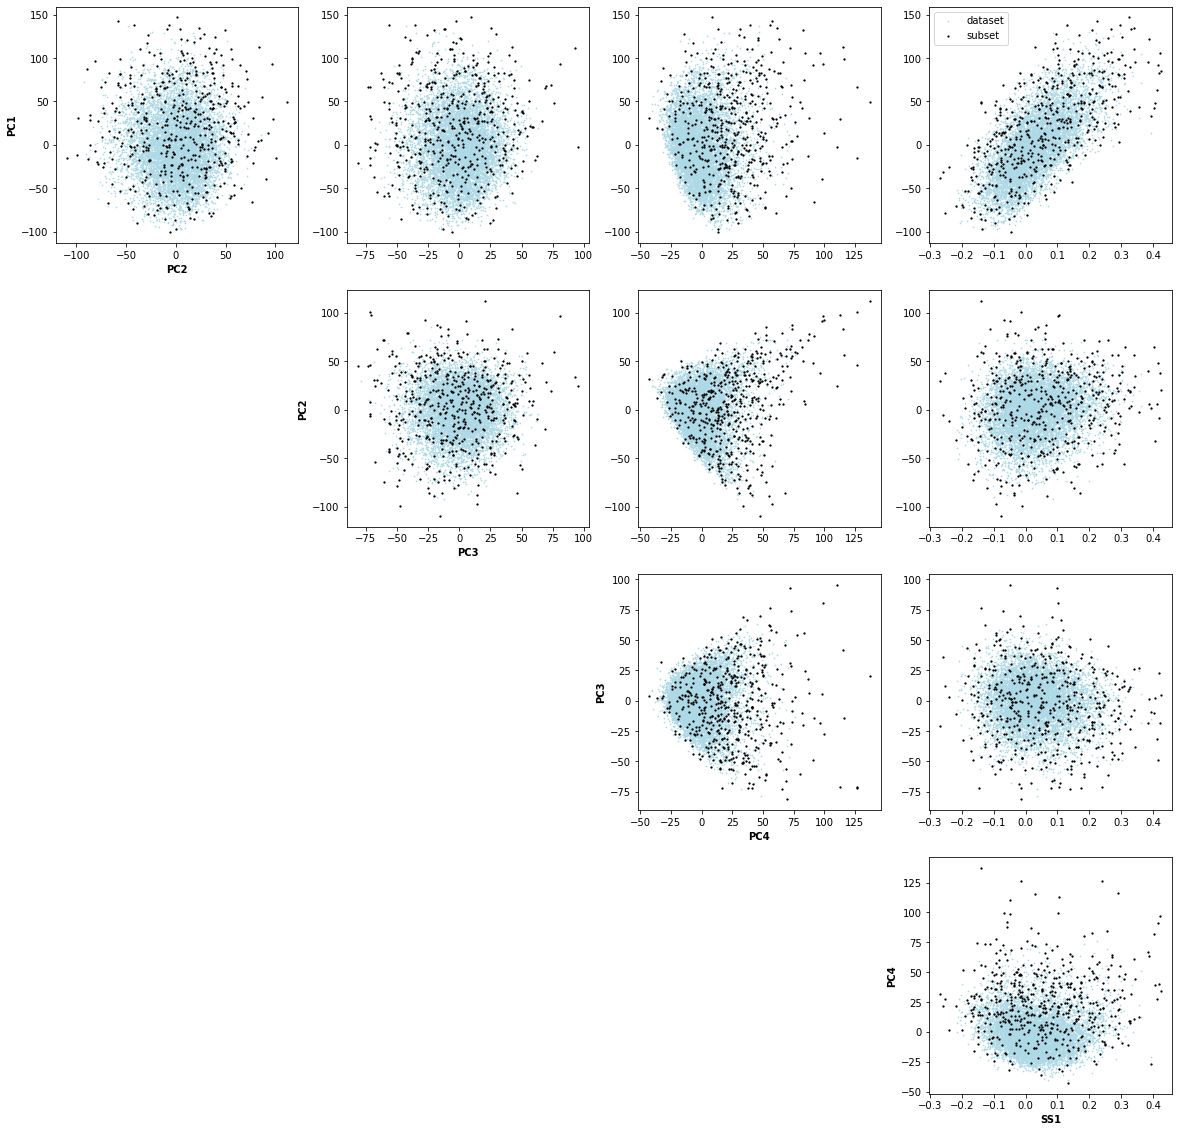

We finally have 509 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 14.99 | interpolation: 0.44 | sigma: 0.4355


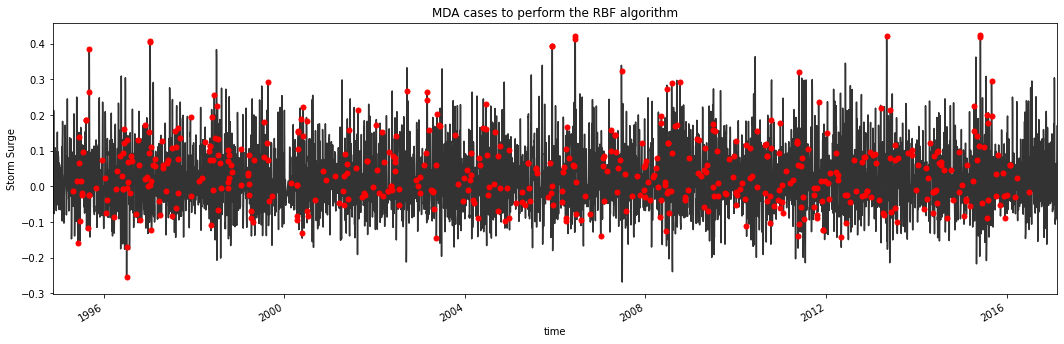

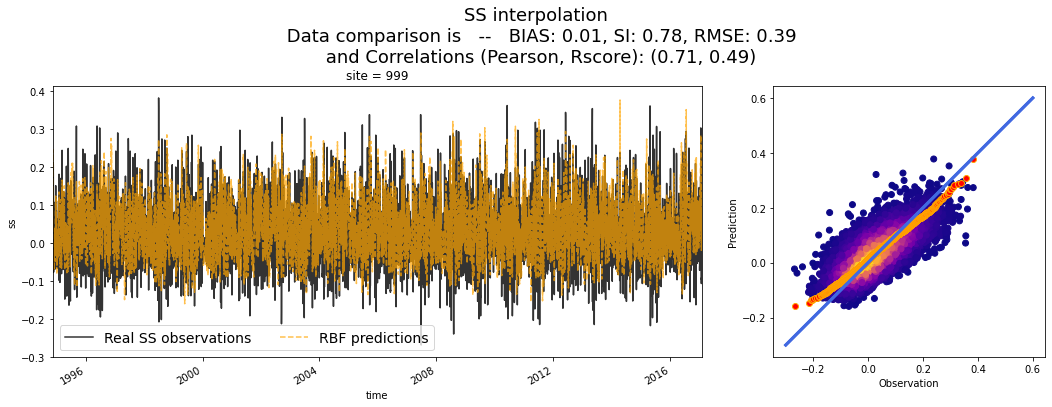


 ------------------------------------------------------------- 


 MDA + RBF with 0.9 per of pcs and 800 samples!! 

 which means 18 PCs... 


 ------------------------------------------------------------- 





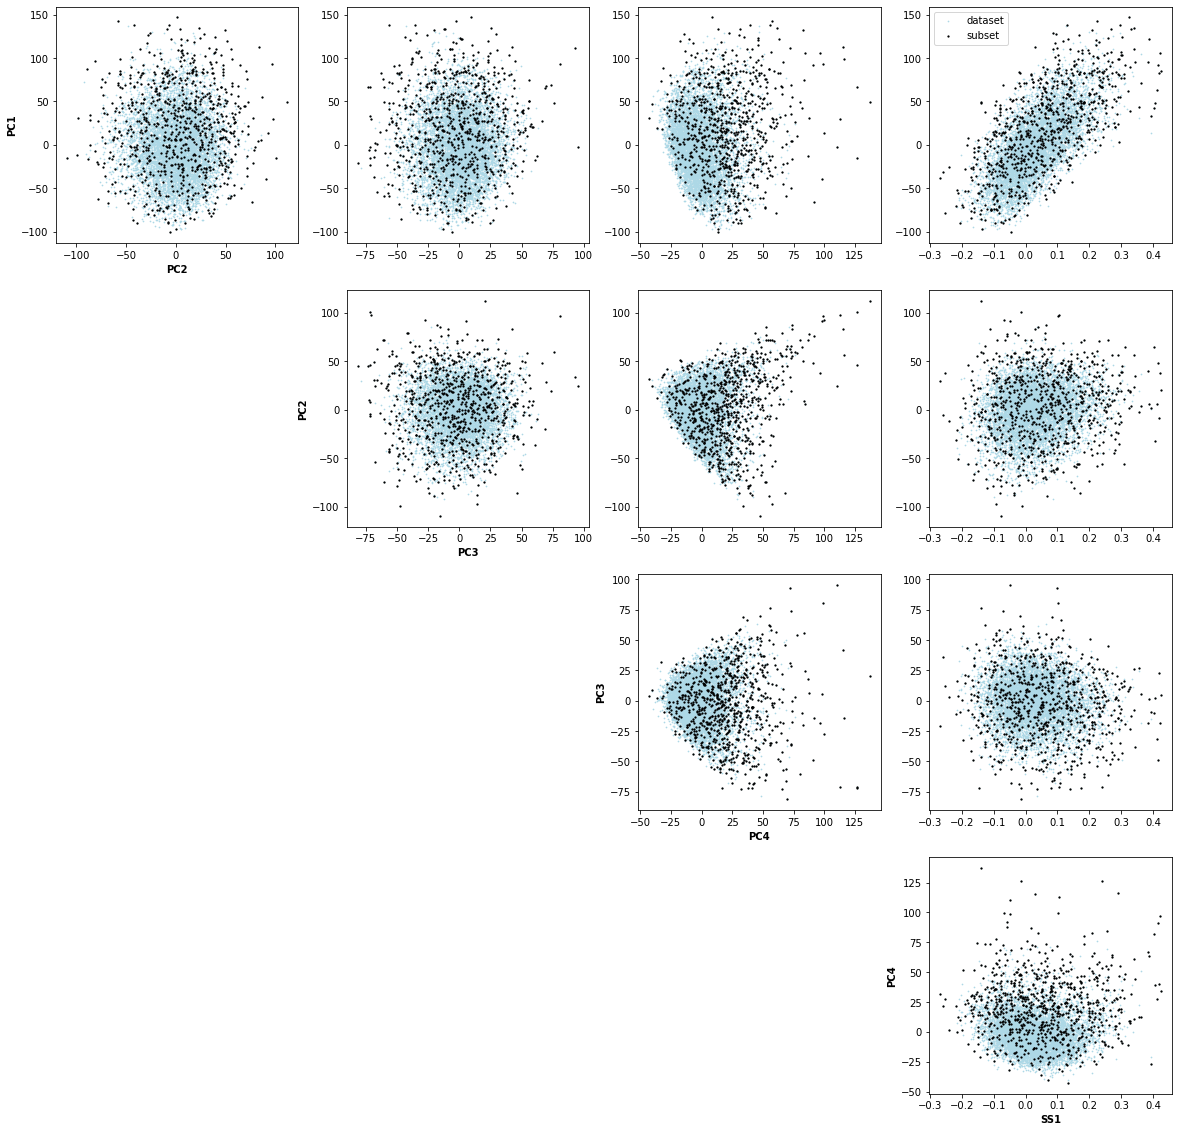

We finally have 809 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 27.56 | interpolation: 0.61 | sigma: 0.6058


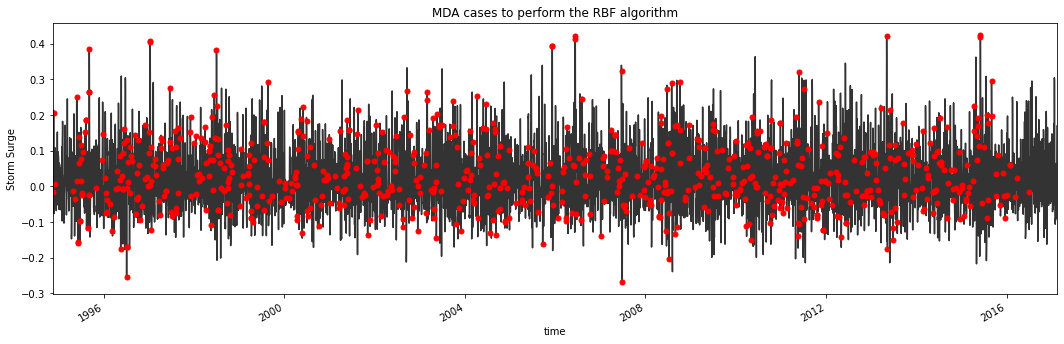

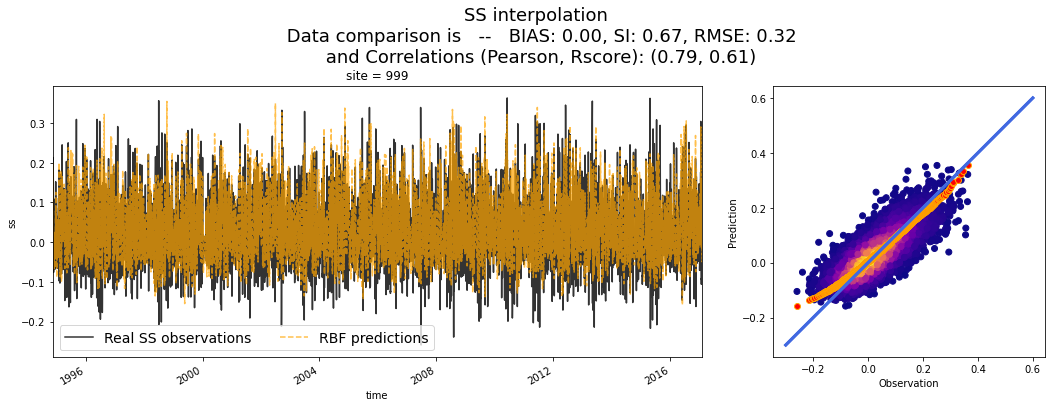


 Lets plot the SS reconstructions for location 3!! 



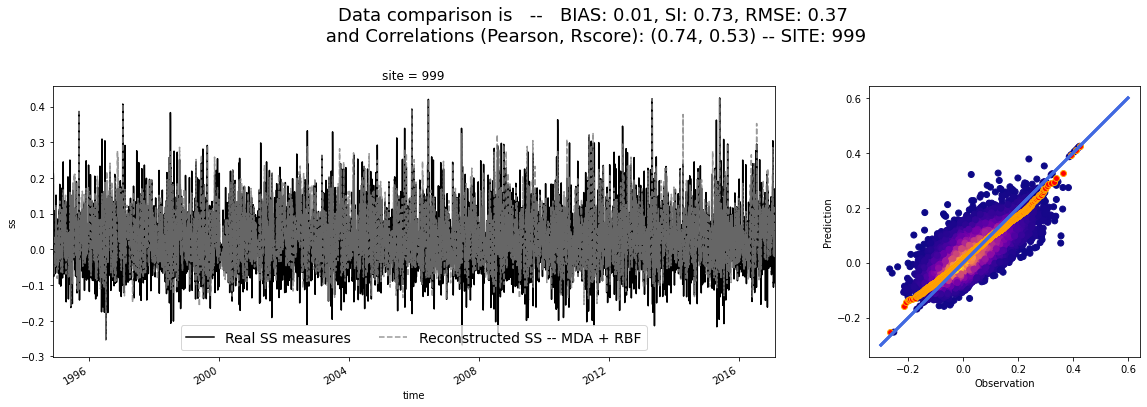

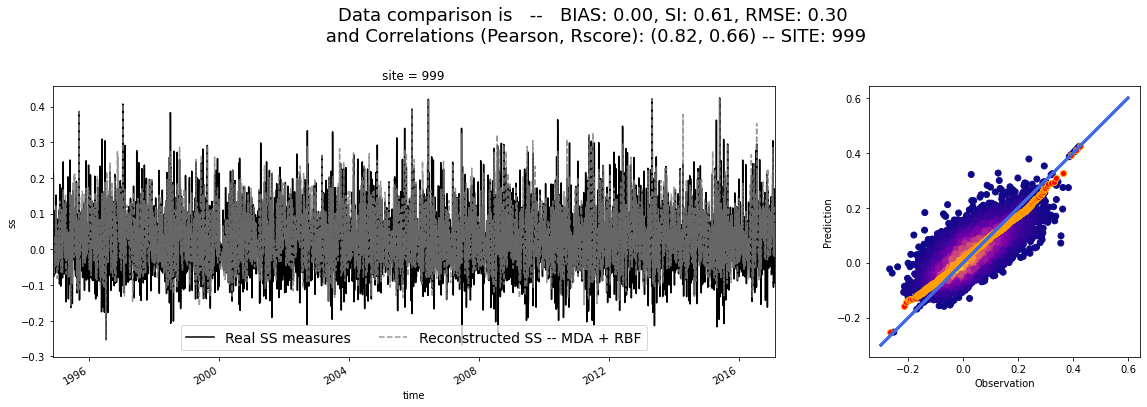


 Lets reconstruct the SS for location 4!! 


 ------------------------------------------------------------- 


 MDA + RBF with 0.85 per of pcs and 500 samples!! 

 which means 12 PCs... 


 ------------------------------------------------------------- 





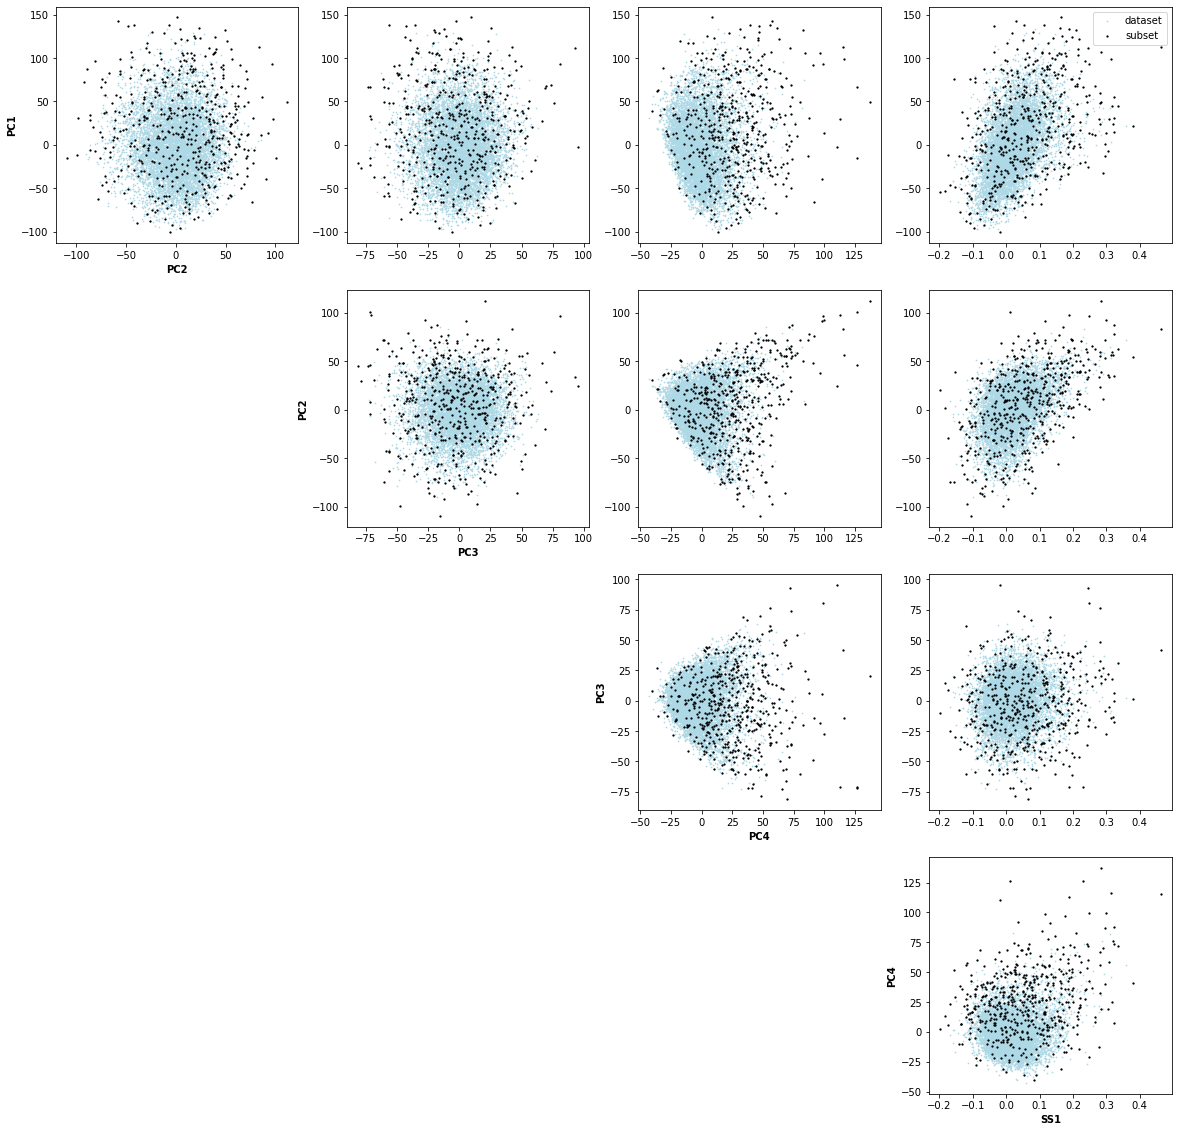

We finally have 510 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 12.32 | interpolation: 0.55 | sigma: 0.5525


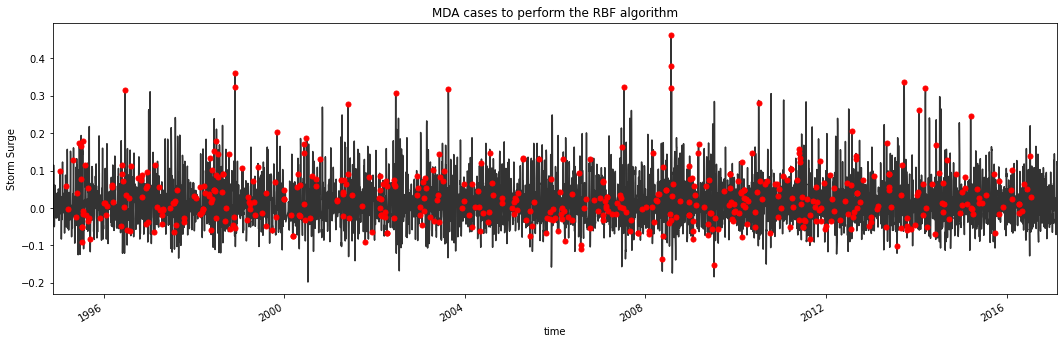

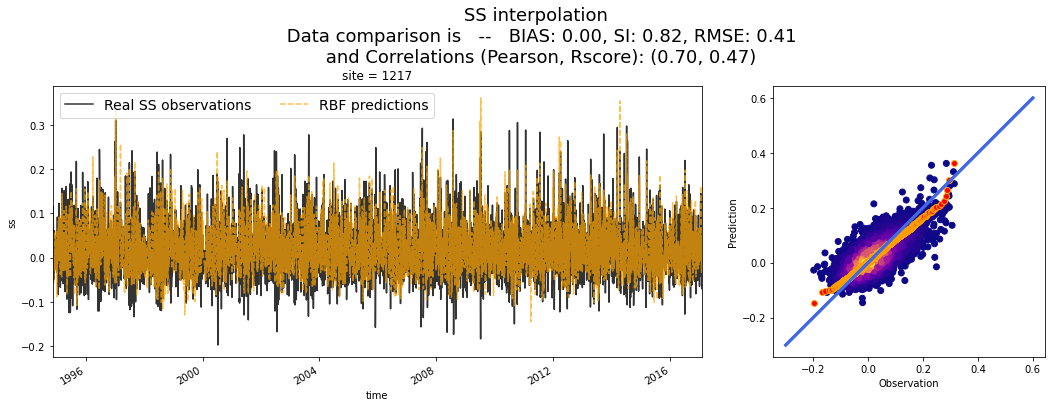


 ------------------------------------------------------------- 


 MDA + RBF with 0.9 per of pcs and 800 samples!! 

 which means 18 PCs... 


 ------------------------------------------------------------- 





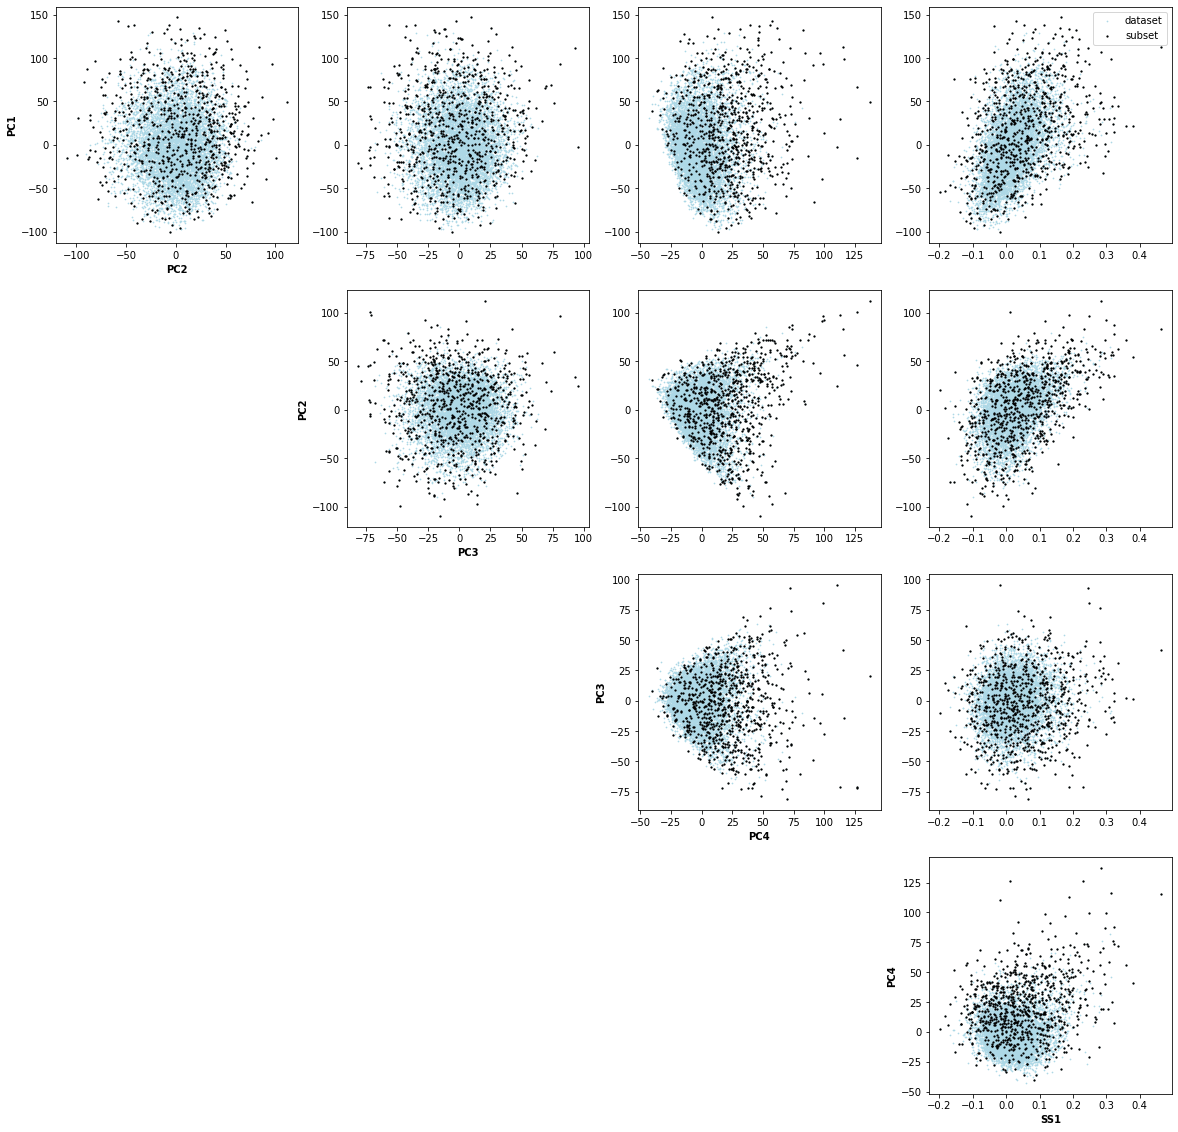

We finally have 810 points to interpolate with RBF!! 


ix_scalar: 0,  optimization: 43.88 | interpolation: 0.61 | sigma: 0.6125


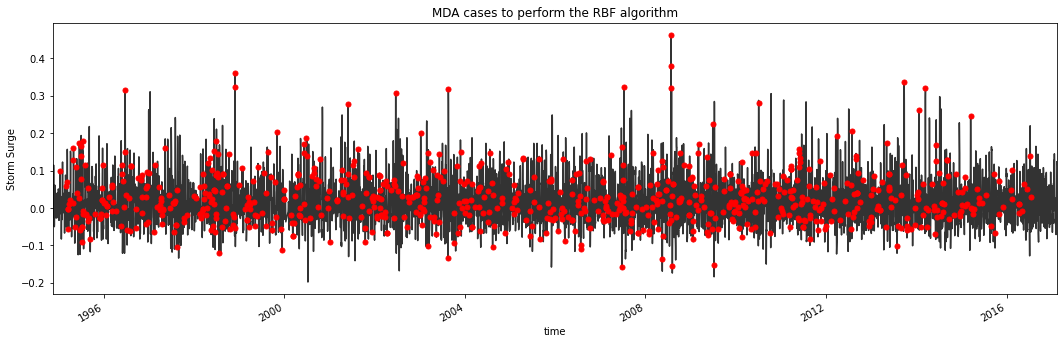

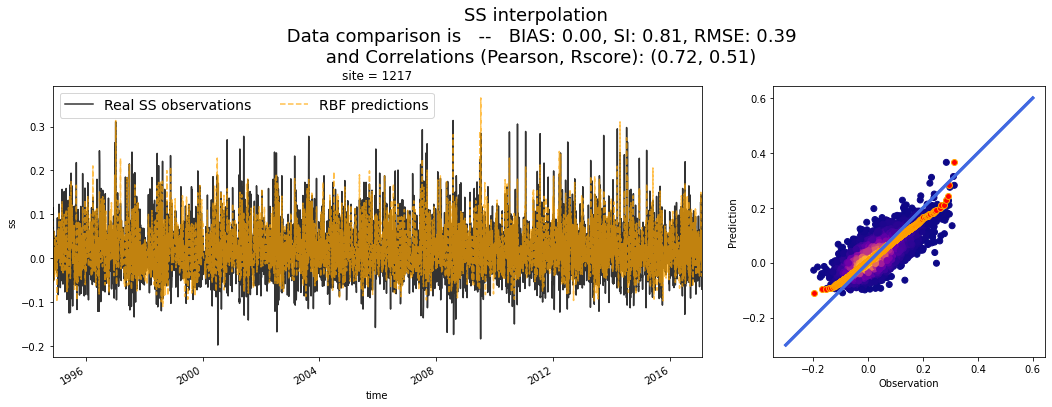


 Lets plot the SS reconstructions for location 4!! 



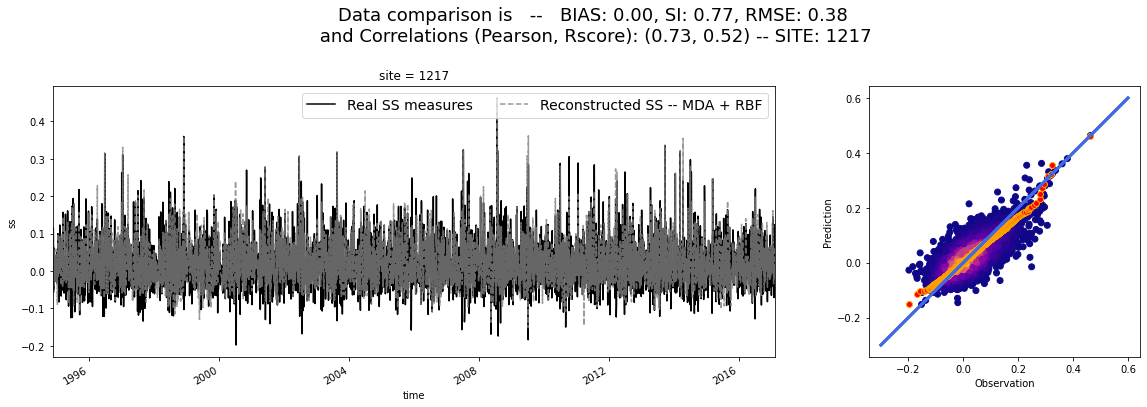

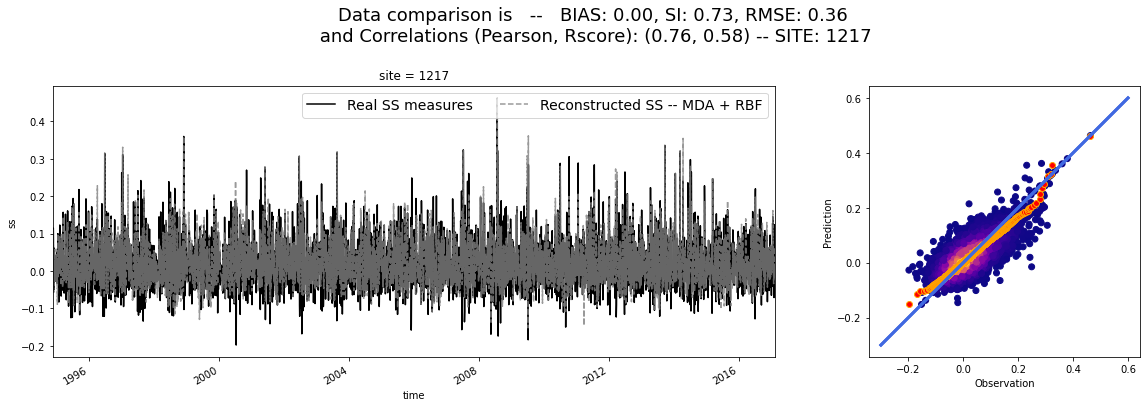

In [4]:
# calculate the MDA + RBF adjustments
interpolated_ss_by_rbf = mda_rbf_model.calc_MDA_RBF(
    selected_shores=np.arange(len(sites_to_analyze[::8])), # indexes in python counter
    percentage_pcs_ini=[0.85,0.90],
    num_samples_ini=[500,800],
    ss_pcs=1, append_extremes=10, try_all=False
)

In [5]:
interpolated_ss_by_rbf

<xarray.Dataset>
Dimensions:     (experiment: 2, site: 4, time: 8109)
Coordinates:
  * site        (site) int64 116 578 999 1217
  * time        (time) datetime64[ns] 1994-11-13 1994-11-14 ... 2017-02-11
  * experiment  (experiment) int64 0 1
Data variables: (12/13)
    ss_interp   (site, experiment, time) float64 0.1749 0.2023 ... 0.04516
    perpcs      (site, experiment) float64 0.85 0.9 0.85 0.9 0.85 0.9 0.85 0.9
    nsamples    (site, experiment) int64 500 800 500 800 500 800 500 800
    expl_var    (site, experiment) float64 0.6179 0.6547 ... 0.5235 0.5777
    mae         (site, experiment) float64 0.0519 0.04849 ... 0.03309 0.03061
    mse         (site, experiment) float64 0.004573 0.004125 ... 0.001709
    ...          ...
    bias        (site, experiment) float64 0.006323 0.005316 ... 0.001596
    si          (site, experiment) float64 0.6308 0.6024 ... 0.7659 0.7315
    rmse        (site, experiment) float64 0.3146 0.3078 0.3913 ... 0.385 0.3594
    pearson     (site, experiment) float64 0.7901 0.8112 0.751 ... 0.7316 0.7621
    spearman    (site, experiment) float64 0.7848 0.8043 ... 0.6832 0.7133
    rscore      (site, experiment) float64 0.6145 0.6523 ... 0.5235 0.5771